
Taille du jeu de données d'entraînement: 48
Taille du jeu de données de validation: 5
Taille du jeu de données de test: 12
Liste des étiquettes trouvées : ['O', 'DEPARTURE', 'DESTINATION', 'ESCALE']


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

C:\Users\vikne\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vikne\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

C:\Users\vikne\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vikne\anaconda3\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9988554120063782, 'eval_runtime': 0.6664, 'eval_samples_per_second': 7.503, 'eval_steps_per_second': 1.501, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7840012311935425, 'eval_runtime': 0.7313, 'eval_samples_per_second': 6.837, 'eval_steps_per_second': 1.367, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.627339243888855, 'eval_runtime': 0.6704, 'eval_samples_per_second': 7.458, 'eval_steps_per_second': 1.492, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5355299115180969, 'eval_runtime': 0.9687, 'eval_samples_per_second': 5.162, 'eval_steps_per_second': 1.032, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5079911947250366, 'eval_runtime': 0.4977, 'eval_samples_per_second': 10.047, 'eval_steps_per_second': 2.009, 'epoch': 5.0}
{'train_runtime': 121.6445, 'train_samples_per_second': 1.973, 'train_steps_per_second': 0.123, 'train_loss': 0.7590504328409831, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

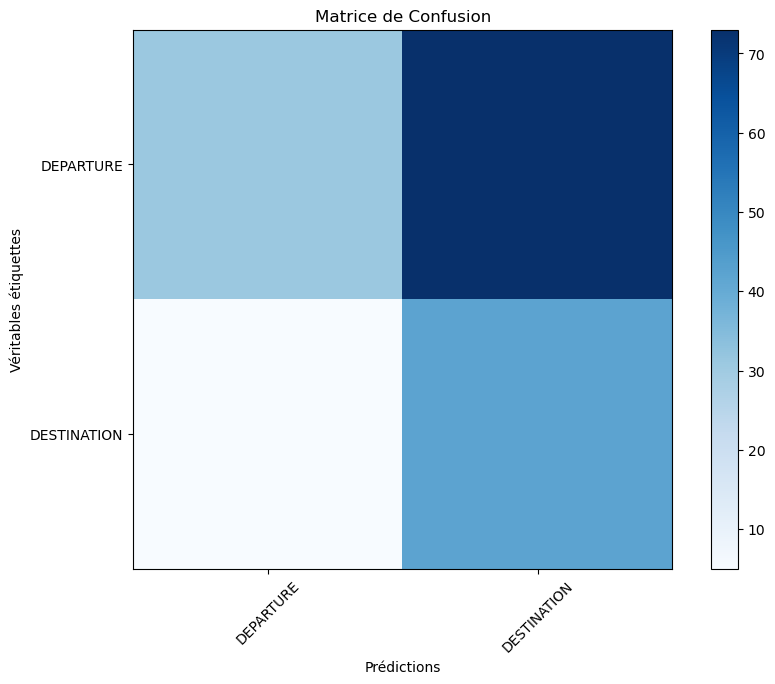

              precision    recall  f1-score   support

   DEPARTURE       0.86      0.30      0.44       104
 DESTINATION       0.37      0.89      0.52        47

    accuracy                           0.48       151
   macro avg       0.61      0.60      0.48       151
weighted avg       0.71      0.48      0.47       151



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import cuda
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import Dataset
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

# Configuration de l'appareil
device = 'cuda' if cuda.is_available() else 'cpu'

# Chemin des données et des résultats
data_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/raw/initial_training_data.csv"
output_dir = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/transformers/bert/token_classification"
os.makedirs(output_dir, exist_ok=True)

# Chargement et mélange du jeu de données initial
data = pd.read_csv(data_path)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Réduction du jeu de données à 30% de sa taille initiale
data_reduced = data.sample(frac=0.3, random_state=42)

# Division des données pour l'entraînement, la validation et le test
train_data, temp_data = train_test_split(data_reduced, test_size=0.25, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.7, random_state=42)

print(f"Taille du jeu de données d'entraînement: {len(train_data)}")
print(f"Taille du jeu de données de validation: {len(valid_data)}")
print(f"Taille du jeu de données de test: {len(test_data)}")

# Transformation des colonnes `tokens` et `ner_tags` en listes
train_data['tokens'] = train_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
train_data['ner_tags'] = train_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
valid_data['tokens'] = valid_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
valid_data['ner_tags'] = valid_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
test_data['tokens'] = test_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
test_data['ner_tags'] = test_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Extraction dynamique des étiquettes
all_labels = set()
for entities in train_data['ner_tags']:
    for entity in entities:
        all_labels.add(entity['label'])

# Création de la liste des étiquettes
label_list = ["O"] + sorted(all_labels)
print(f"Liste des étiquettes trouvées : {label_list}")
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

# Chargement du tokenizer pour BERT
model_checkpoint = "bert-base-cased"  # Changement de Camembert à BERT
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Fonction de Tokenisation et d'Alignement des Étiquettes
def tokenize_and_align_labels(data):
    tokenized_inputs = tokenizer(
        data['tokens'].tolist(),
        truncation=True,
        is_split_into_words=True,
        padding=True,
        return_tensors="pt"
    )
    labels = []
    for i, entities in enumerate(data['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100] * len(word_ids)
        for entity in entities:
            start_idx, end_idx, tag = entity['start'], entity['end'], entity['label']
            token_start, token_end = None, None
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    token_start_pos = len(" ".join(data['tokens'].tolist()[i][:word_id]))
                    if token_start is None and start_idx >= token_start_pos:
                        token_start = idx
                    if end_idx <= token_start_pos + len(data['tokens'].tolist()[i][word_id]):
                        token_end = idx
                        break
            if token_start is not None and token_end is not None and tag in label2id:
                label_ids[token_start:token_end + 1] = [label2id[tag]] * (token_end - token_start + 1)
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenisation des ensembles de données
tokenized_train = tokenize_and_align_labels(train_data)
tokenized_valid = tokenize_and_align_labels(valid_data)
tokenized_test = tokenize_and_align_labels(test_data)

train_dataset = Dataset.from_dict(tokenized_train)
valid_dataset = Dataset.from_dict(tokenized_valid)
test_dataset = Dataset.from_dict(tokenized_test)

# Chargement du modèle BERT pour la classification de tokens
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Paramètres d'entraînement
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_steps=500,
    logging_dir=os.path.join(output_dir, "logs"),
)

# Entraînement du modèle
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
)

trainer.train()
trainer.save_model(output_dir)

# Évaluation sur le jeu de test
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids

# Extraction des entités et des prédictions
def extract_entities(predictions, labels, id2label):
    entities, flat_predictions, flat_labels = [], [], []
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            if predictions[i][j] != -100 and labels[i][j] != -100:
                flat_predictions.append(predictions[i][j])
                flat_labels.append(labels[i][j])
    return flat_predictions, flat_labels

flat_predictions, flat_labels = extract_entities(predicted_labels, labels, id2label)

# Vérification des classes présentes
present_classes = sorted(set(flat_predictions) | set(flat_labels))
target_names = [label_list[i] for i in present_classes]

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(flat_labels, flat_predictions, labels=present_classes)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()
plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
plt.yticks(np.arange(len(target_names)), target_names)
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

# Affichage du rapport de classification
print(classification_report(flat_labels, flat_predictions, target_names=target_names))